In [1]:
# Title:

In [2]:
# packages
import datetime as dt

from quantified_strategies import strategy_utils

import constants
import utils

2024-02-29 21:34:03.208 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU


In [3]:
# parameters

# Trading Parameters
ASSETS = ["VUSA.L", "CNX1.L", utils.CASH]
START = dt.date(2012, 1, 1)
END = dt.date.today()

# Fetch costs involved in trading assets
LONG_OVERNIGHT_COSTS = [constants.LONG_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]
SHORT_OVERNIGHT_COSTS = [constants.SHORT_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]

In [4]:
# Get Data
X, y = utils.get_raw_data(assets=ASSETS, start=START, end=END)

C:\Users\tomw1\PycharmProjects\quantified_strategies\quantified_strategies\scripts\strategy_activation_asset_allocator\utils.py:24: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_data = price_data.pct_change()


In [5]:
import pandas as pd
import typing as t

def run(X_df: pd.DataFrame, y_df: pd.DataFrame, **kwargs) -> t.Dict[str, pd.DataFrame]:
    
    assets = y_df.columns.tolist()
    
    long_costs_df = pd.Series(LONG_OVERNIGHT_COSTS, index=assets)
    short_costs_df = pd.Series(SHORT_OVERNIGHT_COSTS, index=assets)

    # Allocation
    ## Strategy Activation
    alloc = X_df.T.groupby(level=2).sum().T
    alloc = alloc.div(alloc.sum(axis=1), axis=0).fillna(0.0)
    alloc = alloc.reindex(columns=y_df.columns, fill_value=0.0)
    alloc[utils.CASH] = 1 - alloc.sum(axis=1)

    ## Opposite Strategy
    inv_alloc = 1 - alloc[[asset for asset in y_df.columns if asset != utils.CASH]]
    inv_alloc = inv_alloc.div(inv_alloc.sum(axis=1)+1e-8, axis=0)
    inv_alloc[utils.CASH] = (1 - inv_alloc.sum(axis=1)).round(2)
    
    ## HODL
    hodl_alloc = pd.DataFrame(1 / (len(assets) - 1), index=alloc.index, columns=assets)
    hodl_alloc[utils.CASH] = 0.0

    # Get Strategy returns
    strat_ret = (y_df * alloc).sum(axis=1) - (alloc.clip(lower=0.0).dot(long_costs_df) + alloc.clip(upper=0.0).abs().dot(short_costs_df))
    inv_strat_ret = (y_df * inv_alloc).sum(axis=1) - (inv_alloc.clip(lower=0.0).dot(long_costs_df) + inv_alloc.clip(upper=0.0).abs().dot(short_costs_df))
    hodl_ret = (y_df * hodl_alloc).sum(axis=1) - (hodl_alloc.clip(lower=0.0).dot(long_costs_df) + hodl_alloc.clip(upper=0.0).abs().dot(short_costs_df))

    def format_alloc(df: pd.DataFrame) -> pd.DataFrame:
        return df.rename(columns={col: f"w_{col}" for col in df.columns})
    
    df_strat = pd.concat([y_df, format_alloc(df=alloc), strat_ret.to_frame(name="ret")], axis=1)
    df_inv_strat = pd.concat([y_df, format_alloc(df=inv_alloc), inv_strat_ret.to_frame(name="ret")], axis=1)
    df_hodl = pd.concat([y_df, format_alloc(df=hodl_alloc), hodl_ret.to_frame(name="ret")], axis=1)

    return {"strat": df_strat, "inv_strat": df_inv_strat, "hodl": df_hodl}


In [6]:
all_strat_dicts = run(X_df=X, y_df=y)

In [7]:
strat_df = all_strat_dicts["strat"].copy()
inv_strat_df = all_strat_dicts["inv_strat"].copy()
hodl_df = all_strat_dicts["hodl"].copy()

<Axes: >

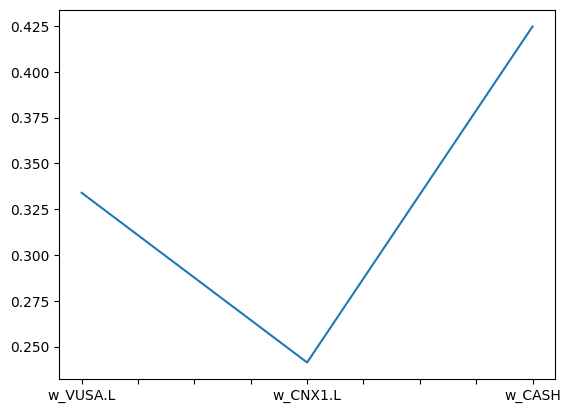

In [8]:
strat_df[[f"w_{asset}" for asset in ASSETS]].mean().plot()

In [9]:
inv_strat_df

,VUSA.L,CNX1.L,CASH,w_VUSA.L,w_CNX1.L,w_CASH,ret
Date,,,,,,,
2012-05-23,0.016518,-0.006161,0.000069,0.5,0.5,0.0,0.005179
2012-05-24,0.003750,-0.001713,0.000069,0.5,0.5,0.0,0.001019
2012-05-25,0.010585,0.012595,0.000068,0.5,0.5,0.0,0.011590
2012-05-29,-0.007394,-0.008269,0.000064,0.5,0.5,0.0,-0.007831
2012-05-30,-0.001862,-0.004929,0.000062,0.5,0.5,0.0,-0.003395
...,...,...,...,...,...,...,...
2024-02-22,0.001740,-0.003730,0.000166,0.5,0.5,0.0,-0.000995
2024-02-23,-0.001868,-0.000266,0.000167,0.5,0.5,0.0,-0.001067
2024-02-26,-0.004171,0.002095,0.000168,0.5,0.5,0.0,-0.001038


In [24]:
FROM_DATE = dt.date(2010, 1, 1)
TO_DATE = dt.date(2023, 12, 31)

In [25]:
hodl_df_ = hodl_df.loc[(hodl_df.index.date >= FROM_DATE) & (hodl_df.index.date <= TO_DATE)]
inv_strat_df_ = inv_strat_df.loc[(inv_strat_df.index.date >= FROM_DATE) & (inv_strat_df.index.date <= TO_DATE)]
strat_df_ = strat_df.loc[(strat_df.index.date >= FROM_DATE) & (strat_df.index.date <= TO_DATE)]

hodl_ret = strategy_utils.get_cumulative_return(returns=hodl_df_["ret"], total=False)
inv_strat_ret = strategy_utils.get_cumulative_return(returns=inv_strat_df_["ret"], total=False)
strat_ret = strategy_utils.get_cumulative_return(returns=strat_df_["ret"], total=False)

hodl_pos = hodl_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)
inv_strat_pos = inv_strat_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)
strat_pos = strat_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)

In [26]:
import matplotlib.pyplot as plt

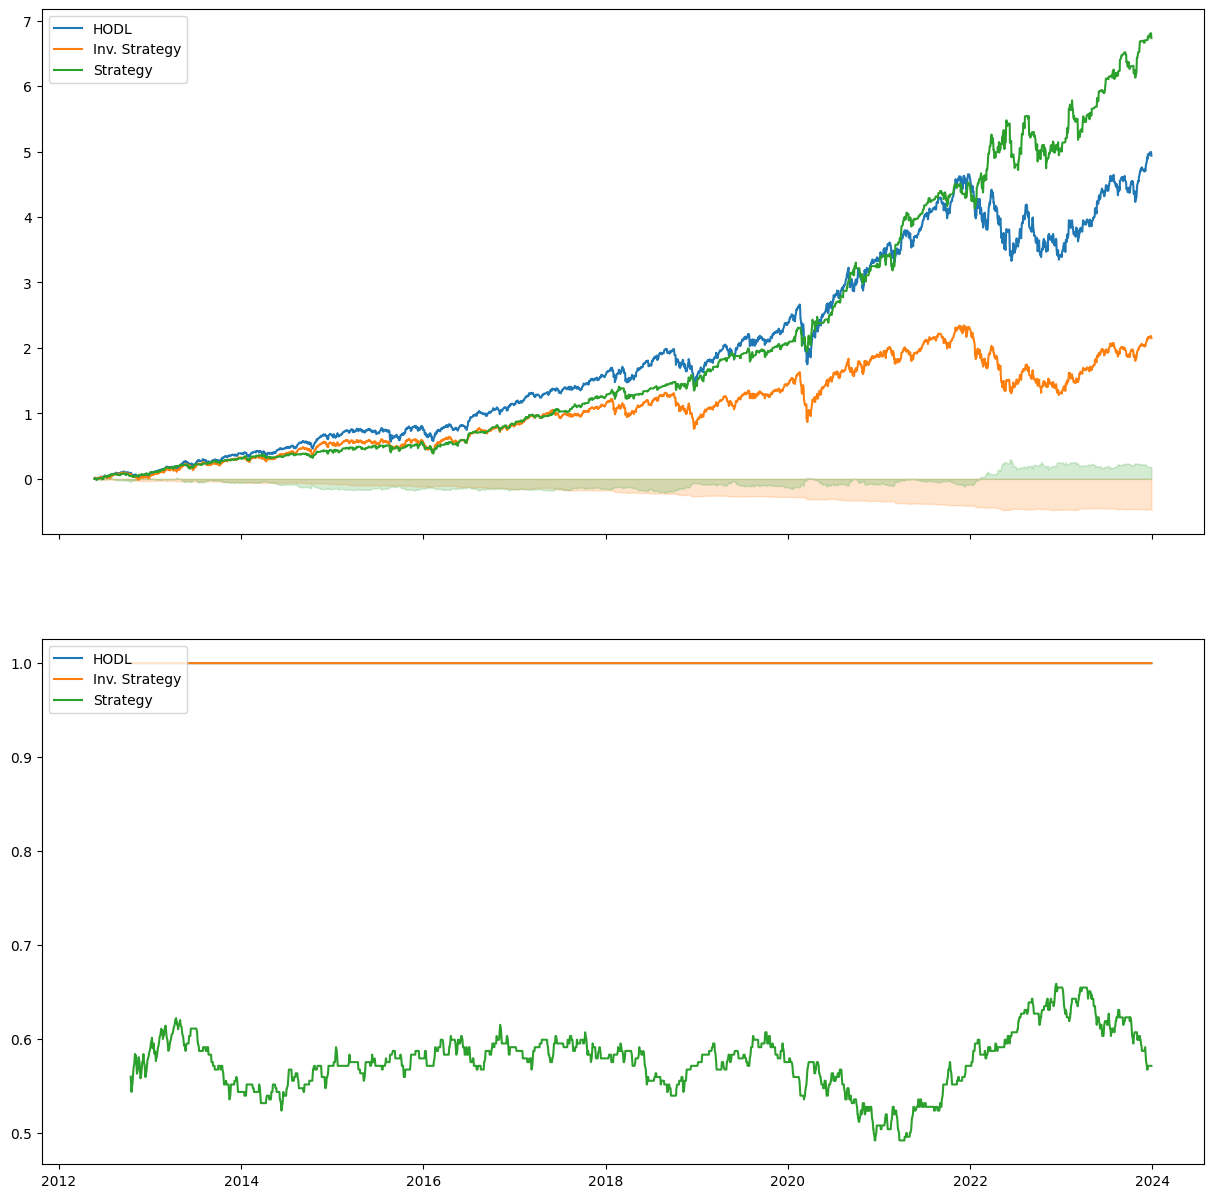

In [27]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(15, 15), sharex="col", nrows=2)

ax[0].plot(hodl_ret, label="HODL", color=colors[0])
ax[0].plot(inv_strat_ret, label="Inv. Strategy", color=colors[1])
ax[0].plot(strat_ret, label="Strategy", color=colors[2])
ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=inv_strat_df_["ret"]-hodl_df_["ret"], total=False), 
    color=colors[1],
    alpha=0.2,
)
ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=strat_df_["ret"]-hodl_df_["ret"], total=False), 
    color=colors[2],
    alpha=0.2,
)
# for i, asset in enumerate(ASSETS):
#     ax[0].plot(strategy_utils.get_cumulative_return(returns=strat_df_[asset], total=False), label=asset, color=colors[3+i])

ax[0].legend()

# Activity
ax[1].plot(hodl_pos.rolling(window=252, min_periods=100).mean(), label="HODL", color=colors[0])
ax[1].plot(inv_strat_pos.rolling(window=252, min_periods=100).mean(), label="Inv. Strategy", color=colors[1])
ax[1].plot(strat_pos.rolling(window=252, min_periods=100).mean(), label="Strategy", color=colors[2])
ax[1].legend(loc="upper left")


plt.show()


In [28]:
desc = pd.concat([
    strategy_utils.describe(returns=strat_df_["ret"], pos=strat_pos, daily=True).to_frame(name="strategy"),
    strategy_utils.describe(returns=inv_strat_df_["ret"], pos=inv_strat_pos, daily=True).to_frame(name="inv_strategy"),
    strategy_utils.describe(returns=hodl_df_["ret"], pos=hodl_pos, daily=True).to_frame(name="hodl")
], axis=1)
desc

C:\Users\tomw1\PycharmProjects\quantified_strategies\quantified_strategies\strategy_utils.py:104: RuntimeWarning: overflow encountered in scalar power
  trade_cagr = (1 + cagr) ** average_hold_period - 1


,strategy,inv_strategy,hodl
Asset,Undefined,Undefined,Undefined
Start,2012-05-23,2012-05-23,2012-05-23
End,2023-12-29,2023-12-29,2023-12-29
Mean Return,0.12032%,0.04432%,0.06531%
Total Return,592.67%,215.08%,493.66%
Median Return,0.14503%,0.08934%,0.09333%
1st Quartile,-0.38943%,-0.40790%,-0.38538%
3rd Quartile,0.65510%,0.55854%,0.55265%
Std Dev Return,1.03274%,1.00830%,0.94196%
CAGR,11.499 bps,3.922 bps,6.087 bps
